In [1]:
import pandas as pd

df = pd.read_csv("data/bangla_political_comments.csv")

In [2]:
df.shape

(1400, 3)

In [3]:
df.isnull().sum()

Comment     0
Label       0
Language    0
dtype: int64

In [4]:
X = df['Comment']
y = df['Label']

c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 8450.42 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_13656\3495667527.py:49: FutureWarnin

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.584000,0.596836,0.682143,0.553245
2,0.520900,0.478900,0.796429,0.789088
3,0.340200,0.501720,0.792857,0.767896
4,0.449200,0.434245,0.796429,0.796119
5,0.369500,0.412633,0.807143,0.809228
6,0.264800,0.469130,0.817857,0.807585
7,0.299200,0.453125,0.825000,0.819489
8,0.178500,0.473025,0.825000,0.817856
9,0.173900,0.500925,0.821429,0.812792
10,0.189500,0.491265,0.825000,0.818690


Evaluation results: {'eval_loss': 0.49126511812210083, 'eval_accuracy': 0.825, 'eval_f1': 0.8186899104440156, 'eval_runtime': 0.8187, 'eval_samples_per_second': 342.013, 'eval_steps_per_second': 21.987, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.92      0.88       191
    Positive       0.79      0.62      0.69        89

    accuracy                           0.82       280
   macro avg       0.81      0.77      0.78       280
weighted avg       0.82      0.82      0.82       280



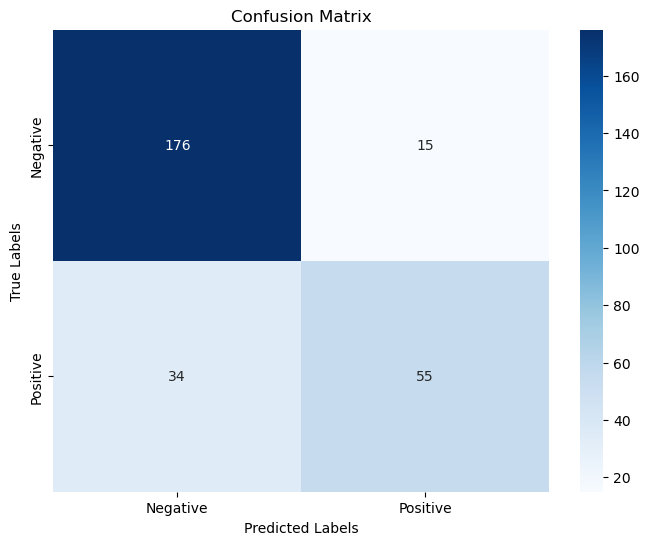

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

le = LabelEncoder()
y_en = le.fit_transform(y)

from datasets import Dataset

data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

device = torch.device('cuda')
model_name = 'distilbert-base-uncased'

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)


data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

import numpy as np

predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids



report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()